In [1]:
import time
import spo
import torch
from matplotlib import pyplot as plt
import numpy as np
from tqdm import tqdm
torch.manual_seed(135)

## Init Data

In [2]:
# generate data for grid network (features and costs)
m = 48 # number of items
n = 1000 # number of data
p = 5 # size of feature
deg = 4 # polynomial degree
weights, x, c = spo.data.knapsack.genData(n+1000, p, m, deg=deg)

In [3]:
weights

array([6, 6, 6, 7, 3, 5, 7, 4, 6, 7, 3, 6, 3, 3, 7, 6, 3, 7, 7, 6, 3, 4,
       6, 3, 5, 6, 3, 3, 4, 3, 4, 3, 6, 7, 4, 4, 6, 4, 4, 5, 7, 6, 3, 3,
       7, 5, 4, 4])

In [4]:
# convert max into min
c = - c

## Optimization Model 

In [5]:
# capacity
cap = 30

In [6]:
#ks_model = spo.model.omo.knapsackModel(weights, cap, solver='gurobi')
ks_model = spo.model.omo.knapsackModel(weights, cap, solver='glpk')

In [7]:
# solve
ks_model.setObj([-i for i in range(m)])
sol, obj = ks_model.solve()
print(sol)
print('Obj: {}'.format(obj))
for i in ks_model.items:
    if sol[i] > 1e-3:
        print(i)

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0]
Obj: -329.0
26
27
29
31
38
42
43
46
47


In [8]:
# relax
ks_model_rel = ks_model.relax()

In [9]:
# solve
ks_model_rel.setObj([-i for i in range(m)])
sol, obj = ks_model_rel.solve()
print(sol)
print('Obj: {}'.format(obj))
for i in ks_model_rel.items:
    if sol[i] > 1e-3:
        print(i)

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.4, 1.0, 1.0]
Obj: -331.0
29
31
37
38
42
43
45
46
47


## Data Loader 

In [10]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

In [11]:
# data split
x_train, x_test, c_train, c_test = train_test_split(x, c, test_size=1000, random_state=246)

In [12]:
# get training data set
ks_dataset_train = spo.data.dataset.optDataset(ks_model, x_train, c_train)

Optimizing for optDataset...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [01:06<00:00, 14.96it/s]


In [13]:
# get training data set for relaxation
ks_dataset_train_rel = spo.data.dataset.optDataset(ks_model_rel, x_train, c_train)

Optimizing for optDataset...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [01:05<00:00, 15.32it/s]


In [14]:
# get test data set
ks_dataset_test = spo.data.dataset.optDataset(ks_model, x_test, c_test)

Optimizing for optDataset...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [01:09<00:00, 14.46it/s]


In [15]:
# get data loader
batch_size = 32
ks_loader_train = DataLoader(ks_dataset_train, batch_size=batch_size, shuffle=True)
ks_loader_train_rel = DataLoader(ks_dataset_train_rel, batch_size=batch_size, shuffle=True)
ks_loader_test = DataLoader(ks_dataset_test, batch_size=batch_size, shuffle=False)

In [16]:
for i, data in enumerate(ks_loader_train):
    x, c, w, z = data
    break

In [17]:
x.shape

torch.Size([32, 5])

In [18]:
c.shape

torch.Size([32, 48])

In [19]:
w.shape

torch.Size([32, 48])

In [20]:
z.shape

torch.Size([32, 1])

## Linear Regression from Scikit-Lear 

In [21]:
from sklearn.linear_model import LinearRegression

In [22]:
# prediction model
reg = LinearRegression()

## Two-Stage 

In [23]:
# build model
twostage_model = spo.twostage.sklearnPred(reg, ks_model)

In [24]:
# training
twostage_model.fit(ks_dataset_train.x, ks_dataset_train.c)

In [25]:
# prediction
c_test_pred = twostage_model.predict(ks_dataset_test.x)

In [26]:
# evaluate
truespo = 0
unambspo = 0
for i in tqdm(range(1000)):
    c_pred_i = c_test_pred[i]
    c_true_i = ks_dataset_test.c[i]
    z_true_i = ks_dataset_test.z[i,0]
    truespo += spo.eval.calTrueSPO(ks_model, c_pred_i, c_true_i, z_true_i)
    unambspo += spo.eval.calUnambSPO(ks_model, c_pred_i, c_true_i, z_true_i)
time.sleep(1)
print('Normalized true SPO Loss: {:.2f}%'.format(truespo / abs(ks_dataset_test.z.sum()) * 100))
print('Normalized unambiguous SPO Loss: {:.2f}%'.format(unambspo / abs(ks_dataset_test.z.sum()) * 100))

100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [03:27<00:00,  4.82it/s]


Normalized true SPO Loss: 2.09%
Normalized unambiguous SPO Loss: 2.09%


In [27]:
# compare solutions
for i, data in enumerate(ks_loader_test):
    # load data
    x, c, w, z = data
    # cuda
    if torch.cuda.is_available():
        x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
    # convert to numpy
    x = x.to('cpu').detach().numpy()
    c = c.to('cpu').detach().numpy()
    w = w.to('cpu').detach().numpy()
    z = z.to('cpu').detach().numpy()
    # predict
    cp = twostage_model.predict(x)
    for j in range(min(10, batch_size)):
        print('Sample {}:'.format(j))
        print('    True cost:', ', '.join(['{:.2f}'.format(-cost) for cost in c[j]]))
        print('    Pred cost:', ', '.join(['{:.2f}'.format(-cost) for cost in cp[j]]))
        # solve cost from prediction
        ks_model.setObj(cp[j])
        wpj, _ = ks_model.solve()
        zpj = np.dot(c[j], wpj)
        print('    True sol: ' + ', '.join(['{:.0f}'.format(x) for x in w[j]]) + ', True obj: {:.2f}'.format(-z[j,0]))
        print('    Pred sol: '+  ', '.join(['{:.0f}'.format(x) for x in wpj]) + ', Pred obj: {:.2f}'.format(-zpj))
        print()
    break

Sample 0:
    True cost: 3.00, 6.00, 12.00, 3.00, 6.00, 9.00, 6.00, 10.00, 5.00, 6.00, 8.00, 3.00, 9.00, 13.00, 3.00, 9.00, 7.00, 6.00, 9.00, 7.00, 5.00, 12.00, 9.00, 4.00, 4.00, 6.00, 4.00, 3.00, 6.00, 16.00, 5.00, 7.00, 10.00, 13.00, 16.00, 16.00, 2.00, 4.00, 2.00, 16.00, 4.00, 6.00, 8.00, 2.00, 3.00, 4.00, 16.00, 8.00
    Pred cost: 2.73, 7.06, 13.91, 2.73, 6.00, 10.63, 7.79, 10.89, 6.59, 7.06, 10.01, 3.78, 10.63, 13.83, 2.73, 13.16, 7.88, 7.27, 13.16, 7.88, 6.59, 13.91, 13.16, 3.96, 5.43, 7.06, 3.96, 2.73, 7.06, 17.33, 7.10, 9.77, 10.82, 11.26, 14.18, 14.32, 1.56, 5.43, 1.56, 17.33, 5.43, 6.00, 10.01, 0.43, 2.73, 5.43, 17.33, 8.19
    True sol: 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, True obj: 114.00
    Pred sol: 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, Pred obj: 114.00

Sample

    True sol: 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, True obj: 51.00
    Pred sol: 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, Pred obj: 51.00

Sample 9:
    True cost: 22.00, 12.00, 8.00, 22.00, 6.00, 10.00, 3.00, 6.00, 18.00, 12.00, 28.00, 7.00, 10.00, 17.00, 22.00, 19.00, 7.00, 23.00, 19.00, 7.00, 18.00, 8.00, 19.00, 15.00, 27.00, 12.00, 15.00, 22.00, 12.00, 20.00, 6.00, 16.00, 19.00, 4.00, 5.00, 11.00, 5.00, 27.00, 5.00, 20.00, 27.00, 6.00, 28.00, 9.00, 22.00, 27.00, 20.00, 15.00
    Pred cost: 18.76, 12.12, 10.02, 18.76, 6.00, 11.87, 3.83, 7.48, 16.55, 12.12, 20.95, 8.12, 11.87, 15.84, 18.76, 19.77, 7.80, 17.76, 19.77, 7.80, 16.55, 10.02, 19.77, 13.78, 21.91, 12.12, 13.78, 18.76, 12.12, 19.15, 7.70, 16.58, 15.70, 3.70, 5.95, 11.14, 6.04, 21.91, 6.04, 19.15, 21.91, 6.00, 20.95, 10

## Linear Regression from PyTorch

In [28]:
from torch import nn

In [29]:
# build linear model
class LinearRegression(nn.Module):
    
    def __init__(self):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(p, m)
    
    def forward(self, x):
        out = self.linear(x)
        return out

## SPO+ 

In [30]:
# init model
reg = LinearRegression()
# cuda
if torch.cuda.is_available():
    reg = reg.cuda()

In [31]:
# set optimizer
optimizer = torch.optim.Adam(reg.parameters(), lr=1e-2)

In [32]:
# init SPO+ loss
criterion = spo.func.SPOPlus(ks_model, processes=4)

Num of cores: 4


In [33]:
# train model
num_epochs = 300
reg.train()
loss_log = []
loss_log_truespo = []
loss_log_unambspo = []
for epoch in range(num_epochs):
    # load data
    for i, data in enumerate(ks_loader_train):
        x, c, w, z = data
        # cuda
        if torch.cuda.is_available():
            x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
        # forward pass
        cp = reg(x)
        loss = criterion.apply(cp, c, w, z).mean()
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    loss_log.append(loss.item())
    if (epoch + 1) % 10 == 0:
        # true SPO
        trueloss = spo.eval.trueSPO(reg, ks_model, ks_loader_test)
        loss_log_truespo.append(trueloss)
        # unambiguous SPO 
        unambloss = spo.eval.unambSPO(reg, ks_model, ks_loader_test)
        loss_log_unambspo.append(unambloss)
        print('Epoch {:3}, Loss: {:8.4f}, True SPO Loss: {:7.4f}%, Unambiguous SPO Loss: {:7.4f}%'. \
              format(epoch+1, loss.item(), trueloss*100, unambloss*100))

Epoch  10, Loss:  40.4125, True SPO Loss:  7.7475%, Unambiguous SPO Loss:  7.7475%
Epoch  20, Loss:  23.7937, True SPO Loss:  2.2334%, Unambiguous SPO Loss:  2.2334%
Epoch  30, Loss:  31.2204, True SPO Loss:  1.3623%, Unambiguous SPO Loss:  1.3623%
Epoch  40, Loss:   4.4843, True SPO Loss:  0.8090%, Unambiguous SPO Loss:  0.8090%
Epoch  50, Loss:   2.1574, True SPO Loss:  0.5920%, Unambiguous SPO Loss:  0.5920%
Epoch  60, Loss:   4.4475, True SPO Loss:  0.5600%, Unambiguous SPO Loss:  0.5600%
Epoch  70, Loss:   1.2376, True SPO Loss:  0.4874%, Unambiguous SPO Loss:  0.4874%
Epoch  80, Loss:   1.7816, True SPO Loss:  0.4331%, Unambiguous SPO Loss:  0.4331%
Epoch  90, Loss:   2.5766, True SPO Loss:  0.4186%, Unambiguous SPO Loss:  0.4186%
Epoch 100, Loss:   3.9630, True SPO Loss:  0.4118%, Unambiguous SPO Loss:  0.4118%
Epoch 110, Loss:   0.5644, True SPO Loss:  0.3914%, Unambiguous SPO Loss:  0.3914%
Epoch 120, Loss:  10.3294, True SPO Loss:  0.3788%, Unambiguous SPO Loss:  0.3788%
Epoc

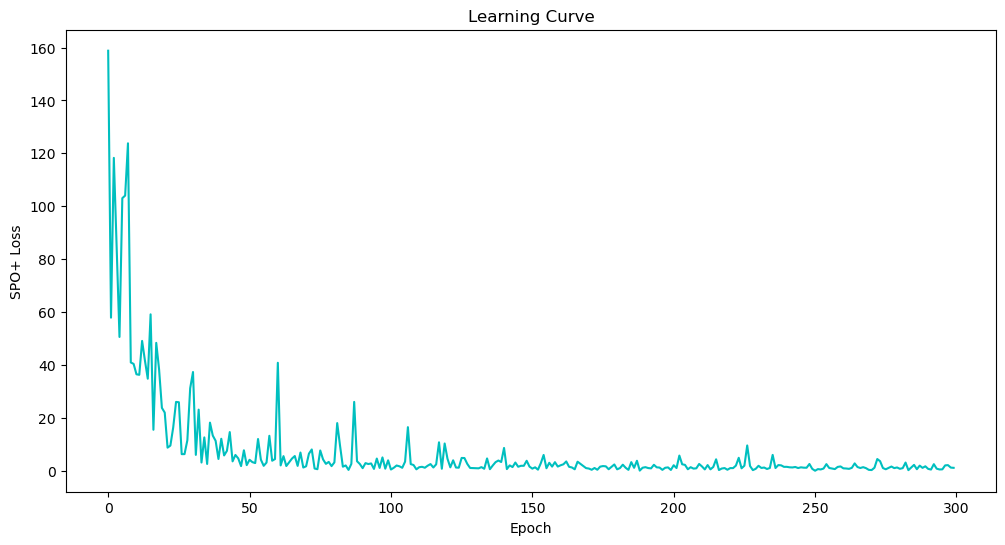

In [34]:
# draw plot
plt.figure(figsize=(12, 6))
plt.plot(loss_log, color='c')
plt.xlabel('Epoch')
plt.ylabel('SPO+ Loss')
plt.title('Learning Curve')
plt.show()

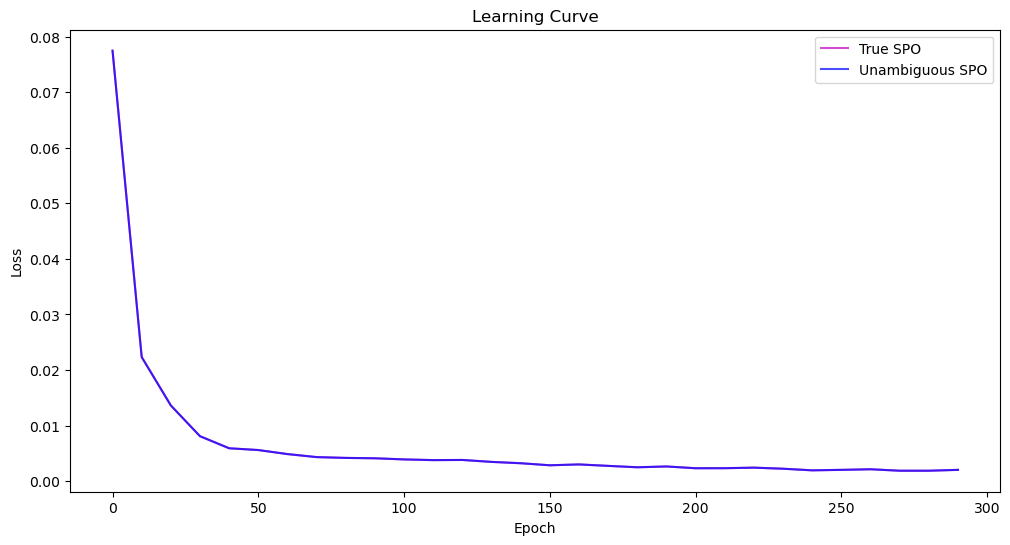

In [35]:
# draw plot
plt.figure(figsize=(12, 6))
plt.plot(range(0, num_epochs, 10), loss_log_truespo, color='m', alpha=0.7, label='True SPO')
plt.plot(range(0, num_epochs, 10), loss_log_unambspo, color='b', alpha=0.7, label='Unambiguous SPO')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curve')
plt.legend()
plt.show()

In [36]:
# evaluate
spoloss = spo.eval.trueSPO(reg, ks_model, ks_loader_test)
print('Normalized true SPO Loss: {:.2f}%'.format(spoloss * 100))
spoloss = spo.eval.unambSPO(reg, ks_model, ks_loader_test)
print('Normalized unambiguous SPO Loss: {:.2f}%'.format(spoloss * 100))

Normalized true SPO Loss: 0.20%
Normalized unambiguous SPO Loss: 0.20%


In [37]:
reg.eval()
# compare solutions
for i, data in enumerate(ks_loader_test):
    # load data
    x, c, w, z = data
    # cuda
    if torch.cuda.is_available():
        x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
    # predict
    cp = reg(x)
    # convert to numpy
    x = x.to('cpu').detach().numpy()
    c = c.to('cpu').detach().numpy()
    w = w.to('cpu').detach().numpy()
    z = z.to('cpu').detach().numpy()
    cp = cp.to('cpu').detach().numpy()
    for j in range(min(10, batch_size)):
        print('Sample {}:'.format(j))
        print('    True cost:', ', '.join(['{:.2f}'.format(-cost) for cost in c[j]]))
        print('    Pred cost:', ', '.join(['{:.2f}'.format(-cost) for cost in cp[j]]))
        # solve cost from prediction
        ks_model.setObj(cp[j])
        wpj, _ = ks_model.solve()
        zpj = np.dot(c[j], wpj)
        print('    True sol: ' + ', '.join(['{:.0f}'.format(x) for x in w[j]]) + ', True obj: {:.2f}'.format(-z[j,0]))
        print('    Pred sol: '+  ', '.join(['{:.0f}'.format(x) for x in wpj]) + ', Pred obj: {:.2f}'.format(-zpj))
        print()
    break

Sample 0:
    True cost: 3.00, 6.00, 12.00, 3.00, 6.00, 9.00, 6.00, 10.00, 5.00, 6.00, 8.00, 3.00, 9.00, 13.00, 3.00, 9.00, 7.00, 6.00, 9.00, 7.00, 5.00, 12.00, 9.00, 4.00, 4.00, 6.00, 4.00, 3.00, 6.00, 16.00, 5.00, 7.00, 10.00, 13.00, 16.00, 16.00, 2.00, 4.00, 2.00, 16.00, 4.00, 6.00, 8.00, 2.00, 3.00, 4.00, 16.00, 8.00
    Pred cost: -6.22, 1.71, 11.32, -2.17, 5.55, 8.88, 5.03, 10.07, -0.40, -1.07, 8.65, -1.42, 8.96, 14.36, -0.40, 7.89, 7.34, 2.47, -1.18, 6.51, 3.71, 13.21, 7.39, 0.75, -1.93, 1.31, 1.34, -2.09, 4.31, 19.03, 2.55, 6.88, 9.27, 12.33, 15.95, 16.74, -8.09, -0.86, -5.19, 17.79, -2.86, 2.83, 8.51, -3.97, -7.36, -2.20, 17.80, 7.45
    True sol: 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, True obj: 114.00
    Pred sol: 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, Pred obj: 114.00

    True sol: 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, True obj: 51.00
    Pred sol: 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, Pred obj: 51.00

Sample 9:
    True cost: 22.00, 12.00, 8.00, 22.00, 6.00, 10.00, 3.00, 6.00, 18.00, 12.00, 28.00, 7.00, 10.00, 17.00, 22.00, 19.00, 7.00, 23.00, 19.00, 7.00, 18.00, 8.00, 19.00, 15.00, 27.00, 12.00, 15.00, 22.00, 12.00, 20.00, 6.00, 16.00, 19.00, 4.00, 5.00, 11.00, 5.00, 27.00, 5.00, 20.00, 27.00, 6.00, 28.00, 9.00, 22.00, 27.00, 20.00, 15.00
    Pred cost: 17.14, 8.27, -0.49, 10.87, 4.37, 5.51, -9.15, 0.47, 13.96, 4.42, 19.67, 1.85, 7.51, 13.35, 0.06, 15.16, 4.96, 17.90, -0.87, 0.22, 14.45, 4.06, 15.78, 11.90, 20.03, 7.64, 11.83, 17.13, 8.71, 16.88, 0.19, 12.41, 14.90, -5.96, -2.09, 7.19, -2.56, 21.01, -1.19, 16.20, 18.00, -0.77, 19.64, 6.78,

## SPO+ with Regularization

In [38]:
# init model
reg = LinearRegression()
# cuda
if torch.cuda.is_available():
    reg = reg.cuda()

In [39]:
# set optimizer
optimizer = torch.optim.Adam(reg.parameters(), lr=1e-2)

In [40]:
# init SPO+ loss
criterion = spo.func.SPOPlus(ks_model, processes=4)

Num of cores: 4


In [41]:
# train model
num_epochs = 300
reg.train()
loss_log = []
loss_log_truespo = []
loss_log_unambspo = []
for epoch in range(num_epochs):
    # load data
    for i, data in enumerate(ks_loader_train):
        x, c, w, z = data
        # cuda
        if torch.cuda.is_available():
            x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
        # forward pass
        cp = reg(x)
        loss = criterion.apply(cp, c, w, z).mean()
        # l1 reg
        l1_lambda = 1e-3
        l1_reg = torch.abs(cp - c).sum(dim=1).mean()
        loss += l1_lambda * l1_reg
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    loss_log.append(loss.item())
    if (epoch + 1) % 10 == 0:
        # true SPO
        trueloss = spo.eval.trueSPO(reg, ks_model, ks_loader_test)
        loss_log_truespo.append(trueloss)
        # unambiguous SPO 
        unambloss = spo.eval.unambSPO(reg, ks_model, ks_loader_test)
        loss_log_unambspo.append(unambloss)
        print('Epoch {:3}, Loss: {:8.4f}, True SPO Loss: {:7.4f}%, Unambiguous SPO Loss: {:7.4f}%'. \
              format(epoch+1, loss.item(), trueloss*100, unambloss*100))

Epoch  10, Loss:  76.7771, True SPO Loss:  7.7678%, Unambiguous SPO Loss:  7.7678%
Epoch  20, Loss:   8.8168, True SPO Loss:  1.8196%, Unambiguous SPO Loss:  1.8196%
Epoch  30, Loss:  20.3770, True SPO Loss:  1.0939%, Unambiguous SPO Loss:  1.0939%
Epoch  40, Loss:  43.3230, True SPO Loss:  0.7044%, Unambiguous SPO Loss:  0.7044%
Epoch  50, Loss:   9.4803, True SPO Loss:  0.5891%, Unambiguous SPO Loss:  0.5891%
Epoch  60, Loss:   3.2026, True SPO Loss:  0.5009%, Unambiguous SPO Loss:  0.5009%
Epoch  70, Loss:   2.9081, True SPO Loss:  0.4709%, Unambiguous SPO Loss:  0.4709%
Epoch  80, Loss:   4.3567, True SPO Loss:  0.4215%, Unambiguous SPO Loss:  0.4215%
Epoch  90, Loss:   1.9160, True SPO Loss:  0.3672%, Unambiguous SPO Loss:  0.3672%
Epoch 100, Loss:   2.5024, True SPO Loss:  0.3401%, Unambiguous SPO Loss:  0.3401%
Epoch 110, Loss:   0.9196, True SPO Loss:  0.3488%, Unambiguous SPO Loss:  0.3488%
Epoch 120, Loss:  13.3514, True SPO Loss:  0.3362%, Unambiguous SPO Loss:  0.3362%
Epoc

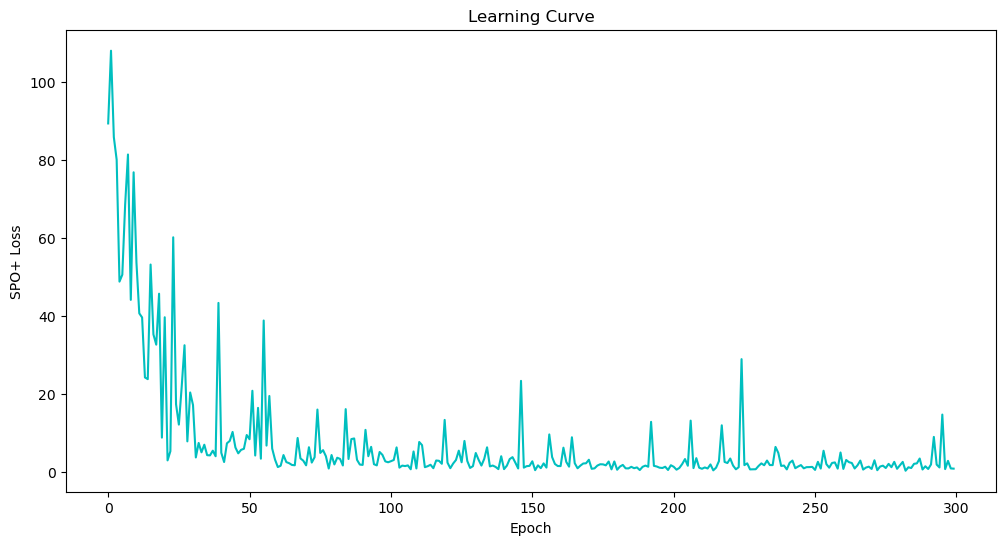

In [42]:
# draw plot
plt.figure(figsize=(12, 6))
plt.plot(loss_log, color='c')
plt.xlabel('Epoch')
plt.ylabel('SPO+ Loss')
plt.title('Learning Curve')
plt.show()

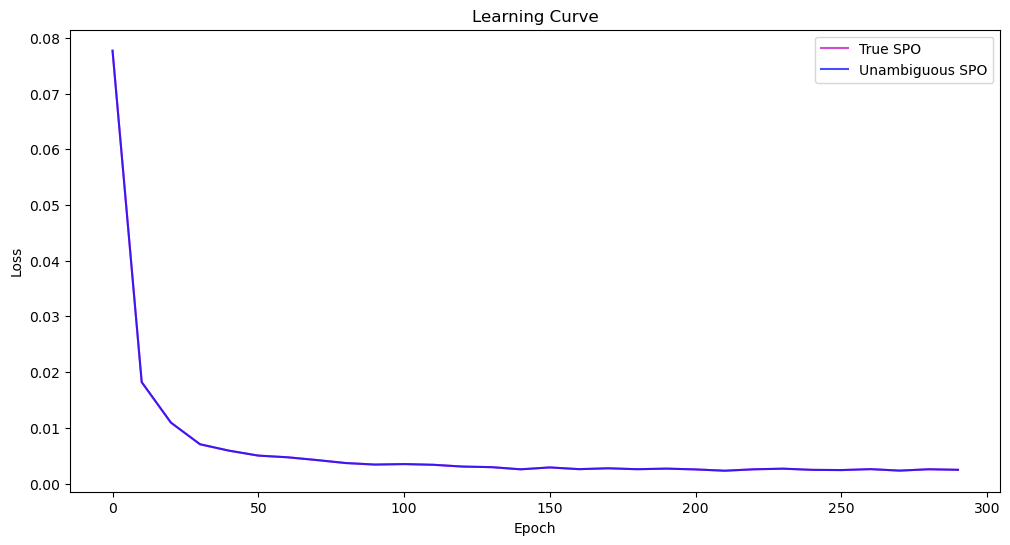

In [43]:
# draw plot
plt.figure(figsize=(12, 6))
plt.plot(range(0, num_epochs, 10), loss_log_truespo, color='m', alpha=0.7, label='True SPO')
plt.plot(range(0, num_epochs, 10), loss_log_unambspo, color='b', alpha=0.7, label='Unambiguous SPO')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curve')
plt.legend()
plt.show()

In [44]:
# evaluate
spoloss = spo.eval.trueSPO(reg, ks_model, ks_loader_test)
print('Normalized true SPO Loss: {:.2f}%'.format(spoloss * 100))
spoloss = spo.eval.unambSPO(reg, ks_model, ks_loader_test)
print('Normalized unambiguous SPO Loss: {:.2f}%'.format(spoloss * 100))

Normalized true SPO Loss: 0.25%
Normalized unambiguous SPO Loss: 0.25%


In [45]:
reg.eval()
# compare solutions
for i, data in enumerate(ks_loader_test):
    # load data
    x, c, w, z = data
    # cuda
    if torch.cuda.is_available():
        x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
    # predict
    cp = reg(x)
    # convert to numpy
    x = x.to('cpu').detach().numpy()
    c = c.to('cpu').detach().numpy()
    w = w.to('cpu').detach().numpy()
    z = z.to('cpu').detach().numpy()
    cp = cp.to('cpu').detach().numpy()
    for j in range(min(10, batch_size)):
        print('Sample {}:'.format(j))
        print('    True cost:', ', '.join(['{:.2f}'.format(-cost) for cost in c[j]]))
        print('    Pred cost:', ', '.join(['{:.2f}'.format(-cost) for cost in cp[j]]))
        # solve cost from prediction
        ks_model.setObj(cp[j])
        wpj, _ = ks_model.solve()
        zpj = np.dot(c[j], wpj)
        print('    True sol: ' + ', '.join(['{:.0f}'.format(x) for x in w[j]]) + ', True obj: {:.2f}'.format(-z[j,0]))
        print('    Pred sol: '+  ', '.join(['{:.0f}'.format(x) for x in wpj]) + ', Pred obj: {:.2f}'.format(-zpj))
        print()
    break

Sample 0:
    True cost: 3.00, 6.00, 12.00, 3.00, 6.00, 9.00, 6.00, 10.00, 5.00, 6.00, 8.00, 3.00, 9.00, 13.00, 3.00, 9.00, 7.00, 6.00, 9.00, 7.00, 5.00, 12.00, 9.00, 4.00, 4.00, 6.00, 4.00, 3.00, 6.00, 16.00, 5.00, 7.00, 10.00, 13.00, 16.00, 16.00, 2.00, 4.00, 2.00, 16.00, 4.00, 6.00, 8.00, 2.00, 3.00, 4.00, 16.00, 8.00
    Pred cost: -1.83, 5.60, 13.88, 1.41, 6.24, 8.86, 6.80, 10.85, 2.57, 6.72, 8.46, -0.40, 9.31, 13.46, 1.97, 9.36, 7.75, 6.00, 10.28, 7.80, 4.03, 13.92, 8.89, 1.81, -0.07, 5.29, 2.00, -1.39, 5.05, 18.17, 2.78, 7.37, 9.95, 13.40, 15.67, 16.70, -3.78, -0.31, -1.49, 18.06, 3.19, 6.32, 8.03, -2.78, 2.34, 0.17, 17.65, 8.11
    True sol: 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, True obj: 114.00
    Pred sol: 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, Pred obj: 114.00

Sampl

    True sol: 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, True obj: 51.00
    Pred sol: 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, Pred obj: 51.00

Sample 9:
    True cost: 22.00, 12.00, 8.00, 22.00, 6.00, 10.00, 3.00, 6.00, 18.00, 12.00, 28.00, 7.00, 10.00, 17.00, 22.00, 19.00, 7.00, 23.00, 19.00, 7.00, 18.00, 8.00, 19.00, 15.00, 27.00, 12.00, 15.00, 22.00, 12.00, 20.00, 6.00, 16.00, 19.00, 4.00, 5.00, 11.00, 5.00, 27.00, 5.00, 20.00, 27.00, 6.00, 28.00, 9.00, 22.00, 27.00, 20.00, 15.00
    Pred cost: 17.40, 10.80, 4.18, 14.69, 4.63, 6.97, -3.01, 3.39, 15.50, 10.08, 19.45, 4.40, 7.86, 12.90, 14.45, 15.72, 5.68, 18.31, 15.41, 5.27, 13.73, 5.46, 16.41, 11.50, 20.00, 10.53, 11.64, 16.88, 9.82, 16.26, 1.42, 12.43, 15.71, 0.06, 0.22, 7.76, 0.76, 20.15, 1.04, 16.22, 20.65, 4.93, 19.55, 6.62, 1

## SPO+ Rel 

In [46]:
# init model
reg = LinearRegression()
# cuda
if torch.cuda.is_available():
    reg = reg.cuda()

In [47]:
# set optimizer
optimizer = torch.optim.Adam(reg.parameters(), lr=1e-2)

In [48]:
# init SPO+ loss
criterion = spo.func.SPOPlus(ks_model_rel, processes=4)

Num of cores: 4


In [49]:
# train model
num_epochs = 300
reg.train()
loss_log = []
loss_log_truespo = []
loss_log_unambspo = []
for epoch in range(num_epochs):
    # load data
    for i, data in enumerate(ks_loader_train_rel):
        x, c, w, z = data
        # cuda
        if torch.cuda.is_available():
            x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
        # forward pass
        cp = reg(x)
        loss = criterion.apply(cp, c, w, z).mean()
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    loss_log.append(loss.item())
    if (epoch + 1) % 10 == 0:
        # true SPO
        trueloss = spo.eval.trueSPO(reg, ks_model, ks_loader_test)
        loss_log_truespo.append(trueloss)
        # unambiguous SPO 
        unambloss = spo.eval.unambSPO(reg, ks_model, ks_loader_test)
        loss_log_unambspo.append(unambloss)
        print('Epoch {:3}, Loss: {:8.4f}, True SPO Loss: {:7.4f}%, Unambiguous SPO Loss: {:7.4f}%'. \
              format(epoch+1, loss.item(), trueloss*100, unambloss*100))

Epoch  10, Loss:  86.2940, True SPO Loss:  6.4753%, Unambiguous SPO Loss:  6.4753%
Epoch  20, Loss:  12.7562, True SPO Loss:  2.1810%, Unambiguous SPO Loss:  2.1810%
Epoch  30, Loss:  20.0065, True SPO Loss:  1.0251%, Unambiguous SPO Loss:  1.0251%
Epoch  40, Loss:  18.7674, True SPO Loss:  0.6589%, Unambiguous SPO Loss:  0.6589%
Epoch  50, Loss:   1.6338, True SPO Loss:  0.5155%, Unambiguous SPO Loss:  0.5155%
Epoch  60, Loss:  19.1768, True SPO Loss:  0.4593%, Unambiguous SPO Loss:  0.4593%
Epoch  70, Loss:   0.9942, True SPO Loss:  0.4709%, Unambiguous SPO Loss:  0.4709%
Epoch  80, Loss:   0.9343, True SPO Loss:  0.3798%, Unambiguous SPO Loss:  0.3798%
Epoch  90, Loss:   3.5986, True SPO Loss:  0.3663%, Unambiguous SPO Loss:  0.3663%
Epoch 100, Loss:  12.7575, True SPO Loss:  0.3759%, Unambiguous SPO Loss:  0.3759%
Epoch 110, Loss:   0.7437, True SPO Loss:  0.3440%, Unambiguous SPO Loss:  0.3440%
Epoch 120, Loss:   4.0031, True SPO Loss:  0.3449%, Unambiguous SPO Loss:  0.3449%
Epoc

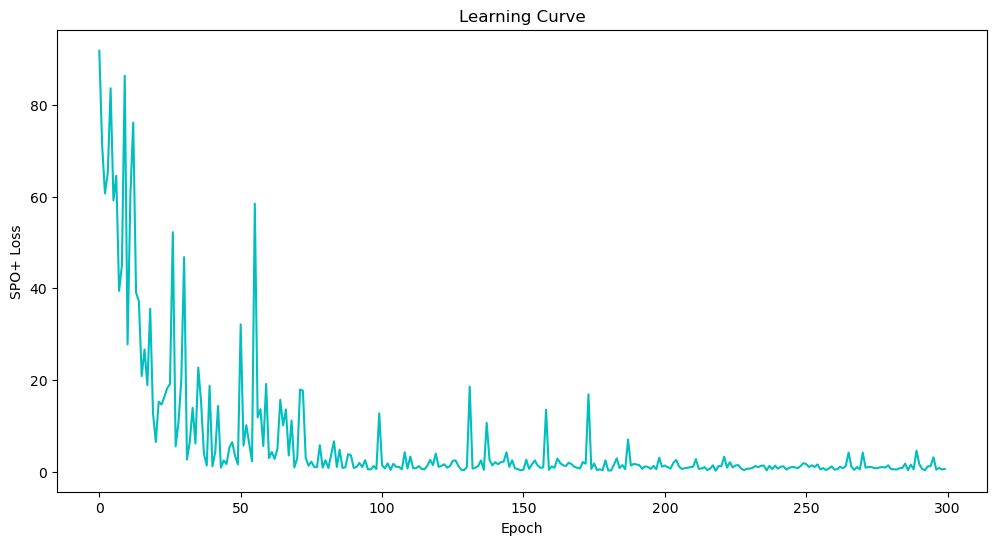

In [50]:
# draw plot
plt.figure(figsize=(12, 6))
plt.plot(loss_log, color='c')
plt.xlabel('Epoch')
plt.ylabel('SPO+ Loss')
plt.title('Learning Curve')
plt.show()

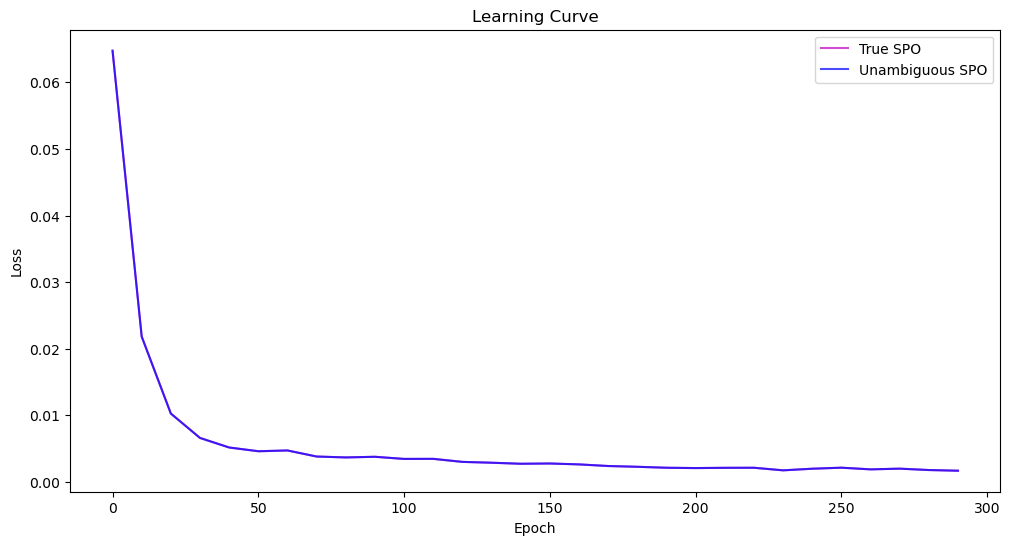

In [51]:
# draw plot
plt.figure(figsize=(12, 6))
plt.plot(range(0, num_epochs, 10), loss_log_truespo, color='m', alpha=0.7, label='True SPO')
plt.plot(range(0, num_epochs, 10), loss_log_unambspo, color='b', alpha=0.7, label='Unambiguous SPO')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curve')
plt.legend()
plt.show()

In [52]:
# evaluate
spoloss = spo.eval.trueSPO(reg, ks_model, ks_loader_test)
print('Normalized true SPO Loss: {:.2f}%'.format(spoloss * 100))
spoloss = spo.eval.unambSPO(reg, ks_model, ks_loader_test)
print('Normalized unambiguous SPO Loss: {:.2f}%'.format(spoloss * 100))

Normalized true SPO Loss: 0.17%
Normalized unambiguous SPO Loss: 0.17%


In [53]:
reg.eval()
# compare solutions
for i, data in enumerate(ks_loader_test):
    # load data
    x, c, w, z = data
    # cuda
    if torch.cuda.is_available():
        x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
    # predict
    cp = reg(x)
    # convert to numpy
    x = x.to('cpu').detach().numpy()
    c = c.to('cpu').detach().numpy()
    w = w.to('cpu').detach().numpy()
    z = z.to('cpu').detach().numpy()
    cp = cp.to('cpu').detach().numpy()
    for j in range(min(10, batch_size)):
        print('Sample {}:'.format(j))
        print('    True cost:', ', '.join(['{:.2f}'.format(-cost) for cost in c[j]]))
        print('    Pred cost:', ', '.join(['{:.2f}'.format(-cost) for cost in cp[j]]))
        # solve cost from prediction
        ks_model.setObj(cp[j])
        wpj, _ = ks_model.solve()
        zpj = np.dot(c[j], wpj)
        print('    True sol: ' + ', '.join(['{:.0f}'.format(x) for x in w[j]]) + ', True obj: {:.2f}'.format(-z[j,0]))
        print('    Pred sol: '+  ', '.join(['{:.0f}'.format(x) for x in wpj]) + ', Pred obj: {:.2f}'.format(-zpj))
        print()
    break

Sample 0:
    True cost: 3.00, 6.00, 12.00, 3.00, 6.00, 9.00, 6.00, 10.00, 5.00, 6.00, 8.00, 3.00, 9.00, 13.00, 3.00, 9.00, 7.00, 6.00, 9.00, 7.00, 5.00, 12.00, 9.00, 4.00, 4.00, 6.00, 4.00, 3.00, 6.00, 16.00, 5.00, 7.00, 10.00, 13.00, 16.00, 16.00, 2.00, 4.00, 2.00, 16.00, 4.00, 6.00, 8.00, 2.00, 3.00, 4.00, 16.00, 8.00
    Pred cost: -5.67, 1.59, 13.87, -5.03, 6.56, 8.89, 3.95, 11.35, -1.33, 1.35, 9.08, -4.16, 9.77, 14.70, -3.46, 8.03, 8.08, 2.47, 6.32, 7.15, 3.63, 13.84, 8.23, 0.92, -2.77, 2.75, 0.85, -1.72, 3.78, 19.44, 2.31, 6.11, 10.48, 14.95, 16.89, 17.59, -6.88, -1.43, -3.67, 19.46, -2.06, 4.15, 8.95, -3.69, -1.10, -1.40, 19.59, 7.74
    True sol: 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, True obj: 114.00
    Pred sol: 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, Pred obj: 114.00


    True sol: 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, True obj: 51.00
    Pred sol: 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, Pred obj: 51.00

Sample 9:
    True cost: 22.00, 12.00, 8.00, 22.00, 6.00, 10.00, 3.00, 6.00, 18.00, 12.00, 28.00, 7.00, 10.00, 17.00, 22.00, 19.00, 7.00, 23.00, 19.00, 7.00, 18.00, 8.00, 19.00, 15.00, 27.00, 12.00, 15.00, 22.00, 12.00, 20.00, 6.00, 16.00, 19.00, 4.00, 5.00, 11.00, 5.00, 27.00, 5.00, 20.00, 27.00, 6.00, 28.00, 9.00, 22.00, 27.00, 20.00, 15.00
    Pred cost: 18.35, 8.57, 0.31, 11.52, 4.14, 6.25, -8.60, 2.71, 13.28, 7.77, 20.35, 0.68, 8.29, 13.87, 10.05, 15.41, 5.40, 20.14, 12.43, 1.22, 14.85, 3.92, 15.38, 11.80, 22.03, 9.20, 11.79, 17.98, 8.50, 16.70, 0.62, 13.51, 15.24, -8.40, -2.41, 8.48, -2.22, 22.13, -0.05, 16.53, 20.29, 0.29, 20.93, 7.03, 

## SPO+ Rel with Regularization 

In [54]:
# init model
reg = LinearRegression()
# cuda
if torch.cuda.is_available():
    reg = reg.cuda()

In [55]:
# set optimizer
optimizer = torch.optim.Adam(reg.parameters(), lr=1e-2)

In [56]:
# init SPO+ loss
criterion = spo.func.SPOPlus(ks_model_rel, processes=4)

Num of cores: 4


In [57]:
# train model
num_epochs = 300
reg.train()
loss_log = []
loss_log_truespo = []
loss_log_unambspo = []
for epoch in range(num_epochs):
    # load data
    for i, data in enumerate(ks_loader_train_rel):
        x, c, w, z = data
        # cuda
        if torch.cuda.is_available():
            x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
        # forward pass
        cp = reg(x)
        loss = criterion.apply(cp, c, w, z).mean()
        # l1 reg
        l1_lambda = 1e-3
        l1_reg = torch.abs(cp - c).sum(dim=1).mean()
        loss += l1_lambda * l1_reg
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    loss_log.append(loss.item())
    if (epoch + 1) % 10 == 0:
        # true SPO
        trueloss = spo.eval.trueSPO(reg, ks_model, ks_loader_test)
        loss_log_truespo.append(trueloss)
        # unambiguous SPO 
        unambloss = spo.eval.unambSPO(reg, ks_model, ks_loader_test)
        loss_log_unambspo.append(unambloss)
        print('Epoch {:3}, Loss: {:8.4f}, True SPO Loss: {:7.4f}%, Unambiguous SPO Loss: {:7.4f}%'. \
              format(epoch+1, loss.item(), trueloss*100, unambloss*100))

Epoch  10, Loss:  73.0460, True SPO Loss:  7.5546%, Unambiguous SPO Loss:  7.5546%
Epoch  20, Loss:  25.1492, True SPO Loss:  1.9039%, Unambiguous SPO Loss:  1.9039%
Epoch  30, Loss:  30.9668, True SPO Loss:  0.9990%, Unambiguous SPO Loss:  0.9990%
Epoch  40, Loss:   3.6512, True SPO Loss:  0.6482%, Unambiguous SPO Loss:  0.6482%
Epoch  50, Loss:   6.1450, True SPO Loss:  0.5358%, Unambiguous SPO Loss:  0.5358%
Epoch  60, Loss:   1.0567, True SPO Loss:  0.4350%, Unambiguous SPO Loss:  0.4350%
Epoch  70, Loss:  25.9846, True SPO Loss:  0.3876%, Unambiguous SPO Loss:  0.3876%
Epoch  80, Loss:   0.7072, True SPO Loss:  0.3779%, Unambiguous SPO Loss:  0.3779%
Epoch  90, Loss:   1.9242, True SPO Loss:  0.3653%, Unambiguous SPO Loss:  0.3653%
Epoch 100, Loss:   0.9819, True SPO Loss:  0.3430%, Unambiguous SPO Loss:  0.3430%
Epoch 110, Loss:   3.9287, True SPO Loss:  0.3130%, Unambiguous SPO Loss:  0.3139%
Epoch 120, Loss:   1.6764, True SPO Loss:  0.2994%, Unambiguous SPO Loss:  0.2994%
Epoc

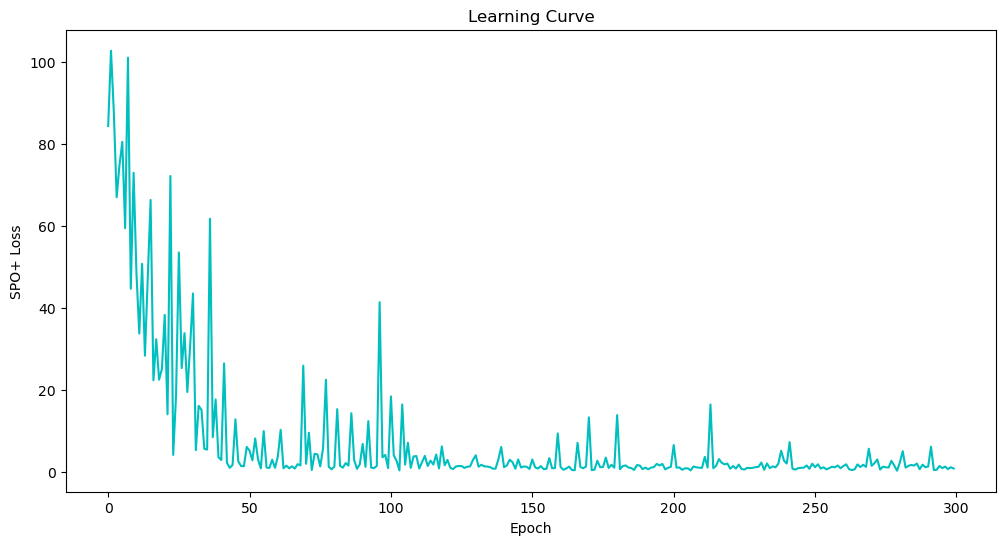

In [58]:
# draw plot
plt.figure(figsize=(12, 6))
plt.plot(loss_log, color='c')
plt.xlabel('Epoch')
plt.ylabel('SPO+ Loss')
plt.title('Learning Curve')
plt.show()

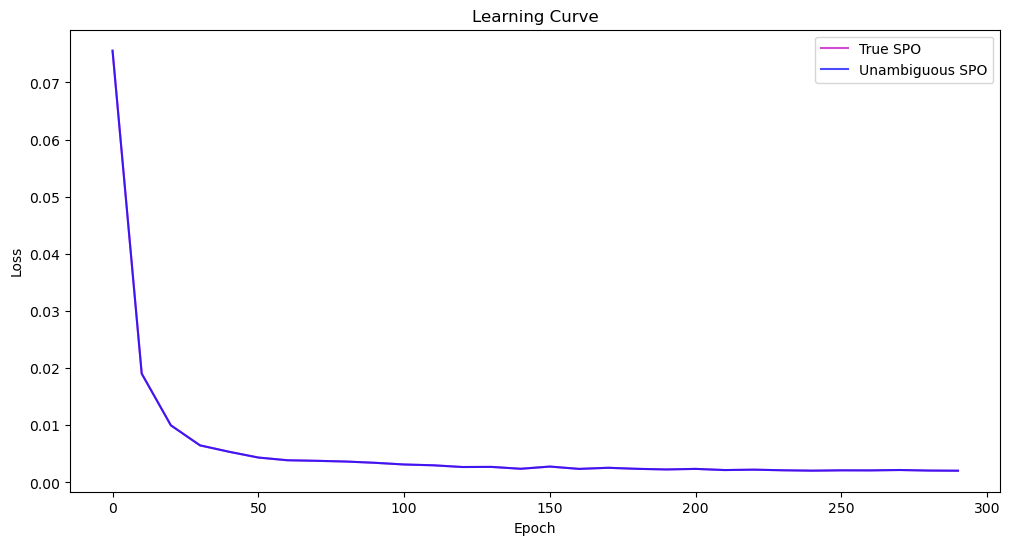

In [59]:
# draw plot
plt.figure(figsize=(12, 6))
plt.plot(range(0, num_epochs, 10), loss_log_truespo, color='m', alpha=0.7, label='True SPO')
plt.plot(range(0, num_epochs, 10), loss_log_unambspo, color='b', alpha=0.7, label='Unambiguous SPO')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curve')
plt.legend()
plt.show()

In [60]:
# evaluate
spoloss = spo.eval.trueSPO(reg, ks_model, ks_loader_test)
print('Normalized true SPO Loss: {:.2f}%'.format(spoloss * 100))
spoloss = spo.eval.unambSPO(reg, ks_model, ks_loader_test)
print('Normalized unambiguous SPO Loss: {:.2f}%'.format(spoloss * 100))

Normalized true SPO Loss: 0.20%
Normalized unambiguous SPO Loss: 0.20%


In [61]:
reg.eval()
# compare solutions
for i, data in enumerate(ks_loader_test):
    # load data
    x, c, w, z = data
    # cuda
    if torch.cuda.is_available():
        x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
    # predict
    cp = reg(x)
    # convert to numpy
    x = x.to('cpu').detach().numpy()
    c = c.to('cpu').detach().numpy()
    w = w.to('cpu').detach().numpy()
    z = z.to('cpu').detach().numpy()
    cp = cp.to('cpu').detach().numpy()
    for j in range(min(10, batch_size)):
        print('Sample {}:'.format(j))
        print('    True cost:', ', '.join(['{:.2f}'.format(-cost) for cost in c[j]]))
        print('    Pred cost:', ', '.join(['{:.2f}'.format(-cost) for cost in cp[j]]))
        # solve cost from prediction
        ks_model.setObj(cp[j])
        wpj, _ = ks_model.solve()
        zpj = np.dot(c[j], wpj)
        print('    True sol: ' + ', '.join(['{:.0f}'.format(x) for x in w[j]]) + ', True obj: {:.2f}'.format(-z[j,0]))
        print('    Pred sol: '+  ', '.join(['{:.0f}'.format(x) for x in wpj]) + ', Pred obj: {:.2f}'.format(-zpj))
        print()
    break

Sample 0:
    True cost: 3.00, 6.00, 12.00, 3.00, 6.00, 9.00, 6.00, 10.00, 5.00, 6.00, 8.00, 3.00, 9.00, 13.00, 3.00, 9.00, 7.00, 6.00, 9.00, 7.00, 5.00, 12.00, 9.00, 4.00, 4.00, 6.00, 4.00, 3.00, 6.00, 16.00, 5.00, 7.00, 10.00, 13.00, 16.00, 16.00, 2.00, 4.00, 2.00, 16.00, 4.00, 6.00, 8.00, 2.00, 3.00, 4.00, 16.00, 8.00
    Pred cost: -1.31, 5.51, 15.11, 2.56, 6.68, 9.21, 6.54, 11.17, 3.97, 6.86, 9.08, 1.02, 9.63, 13.91, 2.26, 10.27, 8.12, 6.51, 13.09, 9.17, 3.87, 13.83, 10.19, 1.92, -0.11, 5.75, 2.16, -1.54, 5.68, 18.82, 4.32, 6.92, 11.22, 13.89, 15.81, 16.34, -1.32, 1.02, -1.53, 18.45, 5.05, 6.39, 8.96, -1.23, 2.03, -0.55, 18.26, 8.52
    True sol: 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, True obj: 114.00
    Pred sol: 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, Pred obj: 114.00

Sam

    True sol: 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, True obj: 51.00
    Pred sol: 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, Pred obj: 51.00

Sample 9:
    True cost: 22.00, 12.00, 8.00, 22.00, 6.00, 10.00, 3.00, 6.00, 18.00, 12.00, 28.00, 7.00, 10.00, 17.00, 22.00, 19.00, 7.00, 23.00, 19.00, 7.00, 18.00, 8.00, 19.00, 15.00, 27.00, 12.00, 15.00, 22.00, 12.00, 20.00, 6.00, 16.00, 19.00, 4.00, 5.00, 11.00, 5.00, 27.00, 5.00, 20.00, 27.00, 6.00, 28.00, 9.00, 22.00, 27.00, 20.00, 15.00
    Pred cost: 18.40, 11.03, 5.27, 19.55, 4.52, 7.62, -2.30, 4.15, 16.36, 11.77, 19.72, 5.24, 7.68, 13.60, 15.67, 15.92, 6.00, 20.15, 17.36, 5.78, 14.73, 5.67, 16.62, 12.11, 21.61, 11.09, 12.03, 17.58, 10.23, 15.88, 2.97, 12.83, 17.06, 1.12, 1.76, 9.36, 2.77, 20.22, 2.09, 17.01, 20.03, 3.67, 20.26, 7.94, 